In [1]:
import requests
import json
import math



#start with the usual imports
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import time
from rdkit import rdBase
print(time.asctime())
print(rdBase.rdkitVersion)
import numpy as np

Thu Oct  8 18:31:18 2020
2020.03.3


In [2]:
#some functions to make things go quicker:
#ChEMBL normally returns 1000 ligands max at a time. This loops through the rest of the ligands and returns the whole lot in a single list.
def getAllRecords(accession, pchembl, total_count):
    ligandList = []
    urlString = "https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=%s&pchembl_value__gt=%s&limit=%s" % (accession, pchembl, total_count)
    webQuery = json.loads(requests.get(urlString).content)
    activities = webQuery['activities']
    ligandList.extend(activities)
    numrepeats = math.ceil(float(total_count)/1000)
    while webQuery['page_meta']['next']:
        urlString = "https://www.ebi.ac.uk"+webQuery['page_meta']['next']
        webQuery = json.loads(requests.get(urlString).content)
        activities = webQuery['activities']
        ligandList.extend(activities)
        print('Loaded', len(ligandList), 'of', total_count)
    return(ligandList)

#this just makes a neater list with only the interesting things: CHEMBLID, common name, pchembl_value, smiles
def parseLigands(ligandList):
    newList = [(item['molecule_chembl_id'], item['molecule_pref_name'], item['pchembl_value'], item['canonical_smiles']) for item in ligandList]
    return(newList)

#this just groups multiple measurements together (into a list) for each ligand
def sortLigands(ligandList):
    newList = []
    chemblids = set([item[0] for item in ligandList])
    for id in chemblids:
        ligands = [item for item in ligandList if item[0]==id]
        newList.append(ligands)
    return(newList)

#this averages the pchembl values for all the measurements, for each ligand.
def averageLigands(ligandList):
    avgList = []
    for item in ligandList:
        if len(item)>1:
            allRecords = [float(measurement[2]) for measurement in item]
            avg = sum(allRecords) / len(allRecords)
            result = [(item[0][0], item[0][1], avg, item[0][3])]
        else:
            result = item
        avgList.append(result)
    return(avgList)


In [3]:
#This is a GABA receptor PROTEIN COMPLEX group from ChEMBL with several hundred buioactivity records
chembl_accession = 'CHEMBL219'

#equivalent to 10uM:
pchembl = 5

print('Counting bioactivities:')
urlString = "https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=%s&pchembl_value__gt=%s" % (chembl_accession, pchembl)
webQuery = json.loads(requests.get(urlString).content)
total_count = webQuery['page_meta']['total_count']
print(total_count)

print('Getting all records:')
ligandList = getAllRecords(chembl_accession, pchembl, total_count)
ligands = parseLigands(ligandList)
print('Of', len(ligands), 'ligand records,')
ligandsSorted = sortLigands(ligands)
print('got', len(ligandsSorted), 'unique ligands')
ligandsAveraged = averageLigands(ligandsSorted)
print('Averaged all', len(ligandsAveraged), 'ligands')


Counting bioactivities:
3171
Loaded 2000 of 3171
Loaded 3000 of 3171
Loaded 3171 of 3171
Of 3171 ligand records,
got 2406 unique ligands
Averaged all 2406 ligands


In [6]:
urlString = "https://www.ebi.ac.uk/chembl/api/data/activity.json?target_chembl_id__exact=%s&pchembl_value__gt=%s&limit=%s" % (chembl_accession, pchembl, total_count)
webQuery = json.loads(requests.get(urlString).content)
activities = webQuery['activities']


In [17]:
import pandas as pd
df = pd.DataFrame(activities)

while len(df)<total_count:
    urlString = "https://www.ebi.ac.uk"+webQuery['page_meta']['next']
    webQuery = json.loads(requests.get(urlString).content)
    activities = webQuery['activities']
    df = pd.concat([df, pd.DataFrame(activities)])
    print(len(df))

2000
3000
3171


In [19]:
fields = ['molecule_chembl_id', 'canonical_smiles', 'pchembl', df['canonical_smiles']

0              c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1
1             COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1
2                COc1ccccc1N1CCN(Cc2ccn(-c3ccccc3)c2)CC1
3                c1ccc(N2CCN(Cc3ccn(-c4ccccc4)c3)CC2)cc1
4      CC1Cc2cccc3c2N1C(=O)C(N1CCN(Cc2ccc(Cl)cc2)CC1)CC3
                             ...                        
166          COc1cccc(C(=O)NCCCCN2CCc3cc(OC)c(O)cc3C2)c1
167           COc1cc2c(cc1O)CN(CCCCNC(=O)c1ccc(F)cc1)CC2
168          COc1cc2c(cc1O)CN(CCCCNC(=O)c1ccc(Cl)cc1)CC2
169          COc1cc2c(cc1O)CN(CCCCNC(=O)c1ccc(Br)cc1)CC2
170           COc1cc2c(cc1O)CN(CCCCNC(=O)c1ccc(I)cc1)CC2
Name: canonical_smiles, Length: 3171, dtype: object

In [4]:
ligandsAveraged

[[('CHEMBL147731', None, '8.40', 'C1=C(c2ccccc2)CCN(Cc2ccn(-c3ccccc3)c2)C1')],
 [('CHEMBL336652', None, '6.57', 'CCCNC1CCc2ccc(O)cc2C1')],
 [('CHEMBL351963',
   None,
   '8.40',
   'Cc1ccc(CN2CCN(C3CCc4cccc5c4N(CC5)C3=O)CC2)cc1')],
 [('CHEMBL26426',
   None,
   '7.66',
   'COc1ccccc1N1CCN(CCNC(=O)C2CCCc3c(OC)cccc32)CC1')],
 [('CHEMBL231374', None, '5.56', 'COc1ccc2c(c1)Cc1ccccc1CCCN(C)CC2')],
 [('CHEMBL4079495', None, '7.02', 'COc1cccc(CCC2=NCCN2CCc2ccccc2)c1')],
 [('CHEMBL382850', None, '6.42', 'CCN1CCc2ccccc2Cc2[nH]c3ccccc3c2CC1')],
 [('CHEMBL345438',
   None,
   '8.00',
   'Cc1ccc(CN2CCN(C3CCc4cccc5c4N(C3=O)C(C)C5)CC2)cc1')],
 [('CHEMBL279247', None, 9.41, 'Cc1nn(C2CCN(Cc3ccccc3)CC2)cc1-c1ccccc1')],
 [('CHEMBL596271', None, '6.90', 'Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21')],
 [('CHEMBL150161',
   None,
   7.612,
   'O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)C1)c1ccc(F)cc1')],
 [('CHEMBL77743', None, '7.72', 'c1ccc(CCN2CCC(c3cc(-c4cccs4)[nH]n3)CC2)cc1')],
 [('CHEMBL2414355',
   None,
   '5.82',


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

In [4]:
df = pd.read_csv('../../docking_sample.csv')
mols = [Chem.MolFromSmiles(i) for i in df['smiles']]

In [10]:
img = Draw.MolsToGridImage(mols, useSVG=True)

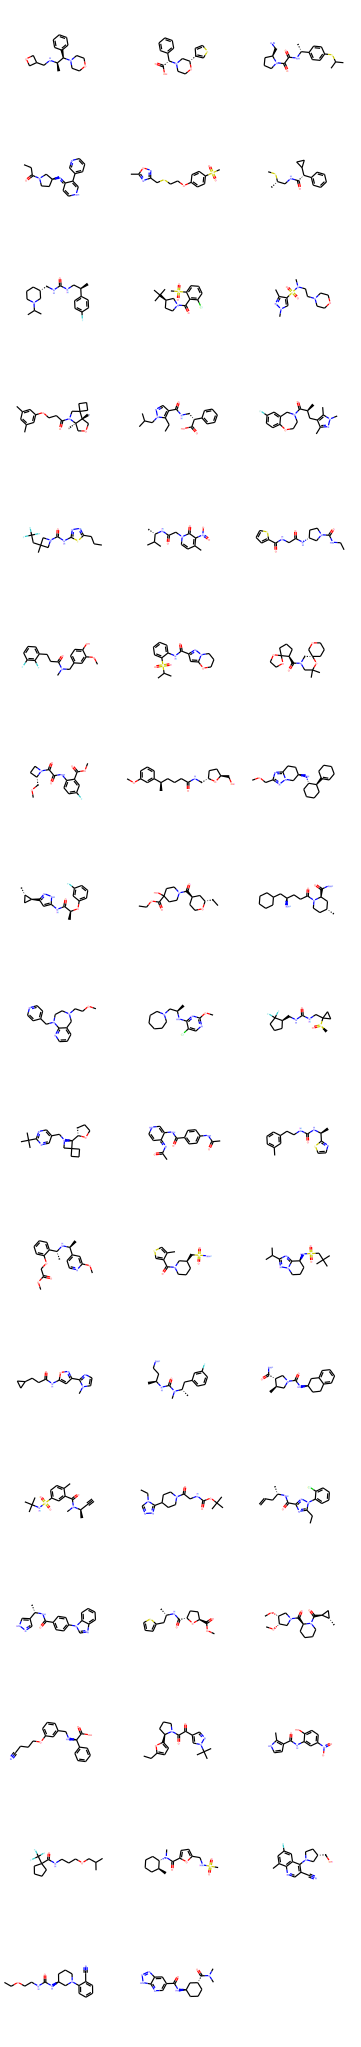

In [12]:
img